# **Penalized Logistic Regression Model, KFold**
---
##Author: Emmanuel Paalam
##Dataset has 13119 rows and 212 columns, preprocessed
## V7: MICEV2 imputation
##Target variable: F3EVERDO

## Import data

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Load the transformed data
X_train = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/X_train_MICEimputed.csv')
X_test = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/X_test_MICEimputed.csv')
y_train = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/y_MICEtrain.csv')
y_test = pd.read_csv('/content/drive/My Drive/research/SURP 2024/colab/data/processed/y_MICEtest.csv')
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(10495, 211), (2624, 211), (10495, 1), (2624, 1)


## Make models

In [3]:
# Define the parameter grid
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'penalty': ['l2', 'l1', 'elasticnet', 'none']
}

# Not all solvers support all penalties, we need to filter incompatible combinations
def is_valid_combination(params):
    solver, penalty = params['solver'], params['penalty']
    if solver in ['newton-cg', 'lbfgs', 'sag', 'newton-cholesky'] and penalty in ['l1', 'elasticnet']:
        return False
    if solver == 'liblinear' and penalty in ['elasticnet', 'none']:
        return False
    return True

param_grid = [params for params in (dict(zip(param_grid.keys(), values))
                                    for values in zip(*param_grid.values()))
              if is_valid_combination(params)]

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV with the valid parameter grid
param_grid_dict = [{'solver': [params['solver']], 'penalty': [params['penalty']]} for params in param_grid]
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=5000), param_grid=param_grid_dict, scoring={'accuracy' : 'accuracy', 'f1_macro' : 'f1_macro'}, cv=10, n_jobs=-1, refit='f1_macro')

param_grid_dict

[{'solver': ['newton-cg'], 'penalty': ['l2']},
 {'solver': ['sag'], 'penalty': ['none']}]

In [5]:
param_grid

[{'solver': 'newton-cg', 'penalty': 'l2'},
 {'solver': 'sag', 'penalty': 'none'}]

In [6]:
# Fit the model
grid_search.fit(X_train, np.ravel(y_train))

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


Best parameters found:  {'penalty': 'l2', 'solver': 'newton-cg'}
Best cross-validation score: 0.81


/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


### Observe metrics

Accuracy: 0.944359756097561
Precision: 0.8195876288659794
Recall: 0.5888888888888889
F1 Score: 0.685344827586207
ROC-AUC: 0.9248875043267566
Specificity: 0.9851316907391674
Test Negative Predictive Value (NPV): 0.9543209876543209
Confusion Matrix:
[[2319   35]
 [ 111  159]]


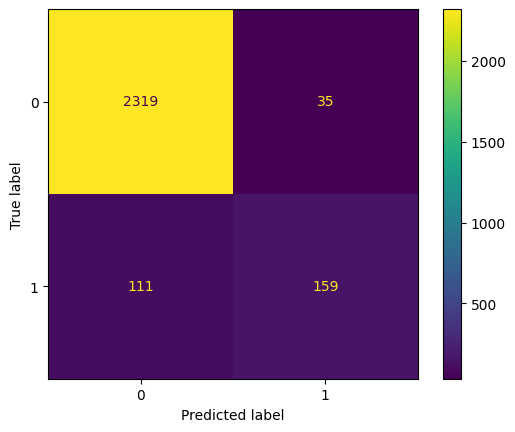

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Calculate specificity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

# Calculate test negative predictive value (NPV)
test_npv = tn / (tn + fn)

# Print the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")
print(f"Specificity: {specificity}")
print(f'Test Negative Predictive Value (NPV): {test_npv}')
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot()